# Introduction

This project was a part of **Machine Learning Specialization with TF2** by [**CLOUDXLAB**](http://cloudxlab.com/).
In this project, we show how to detect and also segment images, based on pre-trained Tensorflow based object detection models.

Detection is identifying a bounding box, instance segmentation requires identifying the pixels that can belong to the object.

We use R-Mask CNN model with inception 2. The R-CNN is does detection in multiple stage with multiple CNN passes. At first it generated proposal regions by studying pixel gradients and edges. Classification is run on each proposal. The final results and bounding boxes are then obtained post-processing of the individual results.

### Importing the Modules
Let us begin by importing the necessary modules, setting the seed to get reproducible results, and defining a function fixColor.

**Note:**

- By default, a color image with Red, Green, and Blue channels will be read in reverse order; ie, Blue, Green, and Red by OpenCv. We could fix this issue by using cv2.COLOR_BGR2RGB transformation effect on the image. So, we shall define a function fixColor to return the RGB form of the given image.

- cv2.cvtColor() method is used to convert an image from one color space to another.

- cv2.COLOR_BGR2RGB returns image in RGB format, which was initially in BGR format as read by cv2.imread().

In [1]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import cv2

Define fixColor function which takes an image as the input argument ad returns the RGB format of the image. Pass cv2.COLOR_BGR2RGB as an input argument along with image to the cv2.cvtColor method.

In [2]:
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Getting the class names
In this section, we will read the coco labels file. This file contains the labels of the object the model was trained against. We will also create a COLORS array which will give a different color for each label.

In [8]:
label_file = "/cxldata/dlcourse/mask_rcnn_model_data/object_detection_classes_coco.txt"

In [9]:
LABELS = open(label_file).read().strip().split("\n")

In [10]:
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [11]:
LABELS[:5]

['person', 'bicycle', 'car', 'motorcycle', 'airplane']

### Getting the Model, Weights and Configs of the Network
The DNN module from CV2 supports reading of tensorflow trained object detection models. We need to load the weight and config for this. For more on this topic refer to https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API

**Note:**

- **cv2.dnn.readNetFromTensorflow(weights, config)** : Reads a network model stored in TensorFlow framework's format.

    - **weights** : path to the **.pb** file with binary protobuf description of the network architecture
    - **config** : path to the **.pbtxt** file that contains text graph definition in protobuf format. Resulting "Net" object is built by text graph using weights from a binary one that let us make it more flexible.

In [17]:
weights = "/cxldata/dlcourse/mask_rcnn_model_data/mask_rcnn_frozen_inference_graph.pb"

In [18]:
config = "/cxldata/dlcourse/mask_rcnn_model_data/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

In [19]:
net = cv2.dnn.readNetFromTensorflow(weights, config)

### Reading and Preprocessing the image
It's time for reading the image file and converting it to a blob.

**Note:**

- In the context of deep learning, a **blob** is also the entire image pre-processed and prepared for classification/training. Such pre-processing usually entails mean subtraction and scaling.

- **cv2.dnn.blobFromImage** : a deep learning method from OpenCV that creates 4-dimensional blob from image. Optionally resizes and crops the image from the center, subtract mean values, scales values by scale factor, swap Blue and Red channels.

    - **image** : input image (with 1-, 3- or 4-channels).
    - **swapRB** : flag which indicates that swap first and last channels in a 3-channel image is necessary.
    - **crop** : flag which indicates whether the image will be cropped after resize or not.
- **net.setInput(blob)** : Sets the input value **blob** for the network **net**.

- **cv2.imread** : Reads an image.

- **plt.imshow(image)** : Displays data as an image

In [24]:
img = cv2.imread('/cxldata/dlcourse/mask_rcnn_model_data/dining_table.jpg')

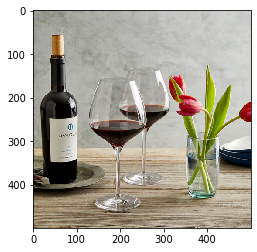

In [25]:
plt.imshow(fixColor(img))

In [26]:
# Use cv2.dnn.blobFromImage to get the blob of the input image.
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)

In [27]:
# Set blob as input to the network net using setInput.
net.setInput(blob)

### Getting the Masks and Bounding Boxes
Let us perform the forward pass of the image through **net.**

Remember, we have already set the input for the network **net** using **net.setInput** in the previous slide.

Now, we shall use **net.forward** to get the masks and the co-ordinates of the bounding boxes.

**Note:**

- Remember,

    - Detection refers to identifying a bounding box
    - instance segmentation means identifying the pixels that can belong to the object.
- net.forward : Perform a forward pass of the Mask R-CNN. It returns

(1) the bounding box coordinates of the objects in the image along with classID, confidence scores from the output layer named 'detection_out_final' (2) the pixel-wise segmentation for each specific object from the output layer named ‘detection_masks‘.

Use net.forward to get the masks and bounding boxes of the detected objects in the input image.

In [31]:
(boxes, masks_polygons) = net.forward(["detection_out_final",
"detection_masks"])

The boxes have classID, confidence scores and 4 points identifying the bounding box. This bounding box is normalized and has to be multiplied by the actual size of the image to get actual values.

In [32]:
boxes.shape

(1, 1, 7, 7)

The boxes have classID, confidence scores and 4 points identifying the bounding box. This bounding box is normalized and has to be multiplied by the actual size of the image to get actual values.

In [33]:
masks_polygons.shape

(100, 90, 15, 15)

The masks_polygons have

- masks corresponding to the 100 detections
- each detection has 90 classes. (We would be considering the classID whose confidence is greater than threshold).
- a matrix denoted as a 15 x 15 mask polygon of the detected object

### Understanding Mask Processing
We have obtained 100 detections along with their corresponding bounding boxes and mask polygons.

But here is a caveat - we need to filter these detections.

The network might sometimes tend to detect irrelevant objects from the image.

Even here, we could not see 100 objects in our input picture.

Thus, we would only consider the most confident detections (the detections whose confidence score > 0.9 (let us call these as valid detections)).

We would do this filtering using the below steps.

- If the box confidence score exceeds the threshold, we also process the mask polygons to create the binary format of the mask as follows:

    - Identify all pixels that the mask_polygon covers
    - Resize this mask polygon to the shape of the original mask
    - Now, if the pixel confidence exceeds the threshold create a mask
    - ROI is Region of Interest in the actual picture. Let's color all of the pixels in the ROI
    - The color of ROI is made into a blend of its actual colors and color allocated to classID. Finally, everything is printed.
    
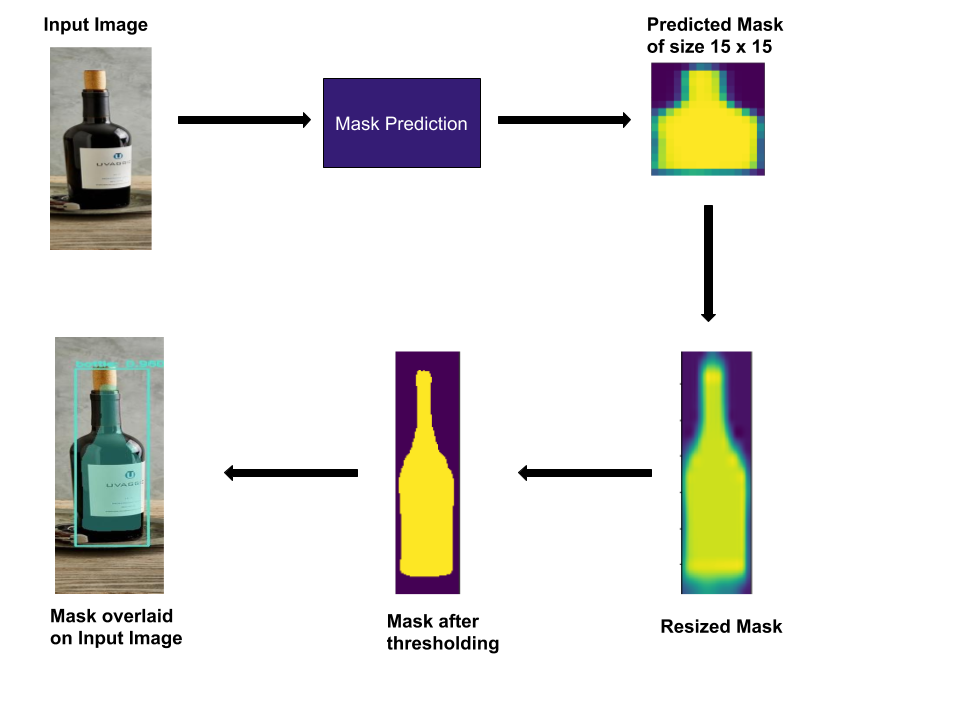

### Filtering and Visualizing the Detections
Now that we have got an idea about mask processing from the previous slide, let us take a closer look at the code by understanding each small snippet:

1.

```
for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > threshold:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY
```
- We shall iterate through each detection using for i in range(0, boxes.shape[2]).
- For each detection, we retrieve the classID and confidence score of the detection.
- If the confidence value of the detection is greater than the threshold, we consider it as a valid detection and further proceed to create the mask using the correspong mask polygon for this detection, as follows:

    - Get the height H and width W of the img.
    - Get the bounding boxes of this valid detection using boxes[0, 0, i, 3:7] and normalize the bounding boxes using boxes[0, 0, i, 3:7] * np.array([W, H, W, H]). Thus the normalized bounding boxes of the currect valid detection is stored in box.
    - Get the width boxW and height boxH of the bounding box.

2.
```
    mask = masks_polygons[i, classID]
    plt.imshow(mask)
    plt.show()
    print("Shape of individual mask", mask.shape)
```
- Now, after getting the normalized bounding box coordinates of the current valid detection, we would extract the pixel-wise segmentation for that detection using mask = masks_polygons[i, classID].
- We then visualize the mask and print the shape of it.

3.
```
    mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)
    print ("Mask after resize", mask.shape)
    mask = (mask > threshold)
```
- We shall then resize this 15 x 15 mask to the dimensions of the bounding box (boxW, boxH).
- We then print the shape of the mask after resizing it.
- Then we convert the pixels of the mask to be in binary format using mask = (mask > threshold).

4.
    `roi = img[startY:endY, startX:endX][mask]`
    
Now, we extract the region of interest (ROI) from the image. It is the overlapping area of the mask in the img.

5.
```
    color = COLORS[classID]
    blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")
    img[startY:endY, startX:endX][mask] = blended
```
- Now we get the blended form of the color to mark the ROI using this color. This blended color is nothing but the combination of the actual object roi and the random color color we have generated for each classID.
- Next, by using img[startY:endY, startX:endX][mask] = blended, we impart this blended color on the ROI of the image, thus forming the view of the object being overlapped with the color of ClassID.
6.
```
    color = COLORS[classID]
    color = [int(c) for c in color]
    print (LABELS[classID], color)
    cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
    text = "{}: {:.4f}".format(LABELS[classID], confidence)
    cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
```
- We finally draw the bounding boxes on the img, mark the detect labels along with their corresponding confidence values:
    - We first get the color corresponding to the ClassID.
    - Since each color is a representation of 3 values corresponding to R, G, B, we traverse through each of those values and convert them into integer format.
    - We then draw a rectangle using cv2.rectangle using the coordinate values startX, startY, endX, endY of the bounding boxes of the valid detections.
    - We then create the text with classID and the confidence value of the detection and write that text on the image using cv2.putText.

In [37]:
threshold = 0.9

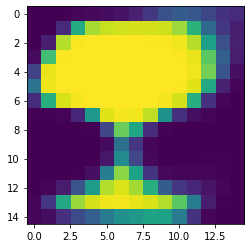

Shape of individual mask (15, 15)
Mask after resize (328, 148)
Mask after threshold (328, 148)
ROI Shape (12764, 3)
wine glass [156, 21, 112]


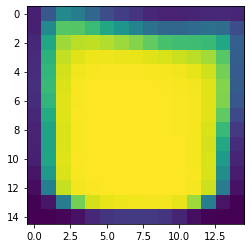

Shape of individual mask (15, 15)
Mask after resize (154, 81)
Mask after threshold (154, 81)
ROI Shape (6072, 3)
vase [166, 56, 167]


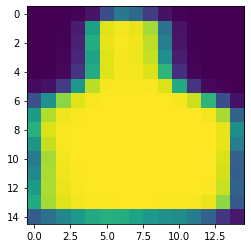

Shape of individual mask (15, 15)
Mask after resize (344, 83)
Mask after threshold (344, 83)
ROI Shape (13497, 3)
bottle [209, 226, 77]


In [38]:
# Use the code below to do the same as described above:
for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > threshold:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        # extract the pixel-wise segmentation for the object, and visualize the mask       
        mask = masks_polygons[i, classID]
        plt.imshow(mask)
        plt.show()
        print ("Shape of individual mask", mask.shape)

        # resize the mask such that it's the same dimensions of
        # the bounding box, and interpolation gives individual pixel positions
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)

        print ("Mask after resize", mask.shape)
        # then finally threshold to create a *binary* mask
        mask = (mask > threshold)
        print ("Mask after threshold", mask.shape)
        # extract the ROI of the image but *only* extracted the
        # masked region of the ROI
        roi = img[startY:endY, startX:endX][mask]
        print ("ROI Shape", roi.shape)

        # grab the color used to visualize this particular class,
        # then create a transparent overlay by blending the color
        # with the ROI
        color = COLORS[classID]
        blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

        # Change the colors in the original to blended color
        img[startY:endY, startX:endX][mask] = blended

        color = COLORS[classID]
        color = [int(c) for c in color]
        print (LABELS[classID], color)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

Finally visualize the image img with the detected objects being highlighted with their corresponding Masks, Bounding Boxes, Class Labels and Confidence Scores.

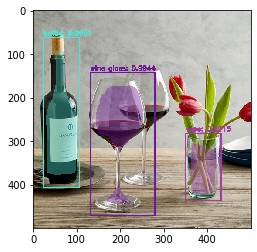

In [39]:
plt.imshow(fixColor(img))